# Cifar-10 Classification and Hyperparameter Tuning with Keras Tuner

## 1. Libraries import

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

## 2. Dataset import and preprocessing

### 2.1 Load the dataset

In [2]:
# Load data from tensorflow.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = load_data()

In [3]:
# Visualize the shapes
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

### 2.2 Preprocess the dataset

In [4]:
# Scale data
x_train = x_train / 255.
x_test = x_test / 255.

In [5]:
"""
NOTE: This notebook does not support tf.data.Dataset, only numpy datasets, 
the next one (and the python modules/scripts) support both.
"""

# # Transform numpy arrays to tensorflow datasets
# train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# # Shuffle and batch train and test data + cache and prefetch for performance
# AUTOTUNE = tf.data.AUTOTUNE
# train = train.cache().prefetch(buffer_size=AUTOTUNE)
# test = test.cache().prefetch(buffer_size=AUTOTUNE)

### 2.3 Visualize the dataset

In [6]:
# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

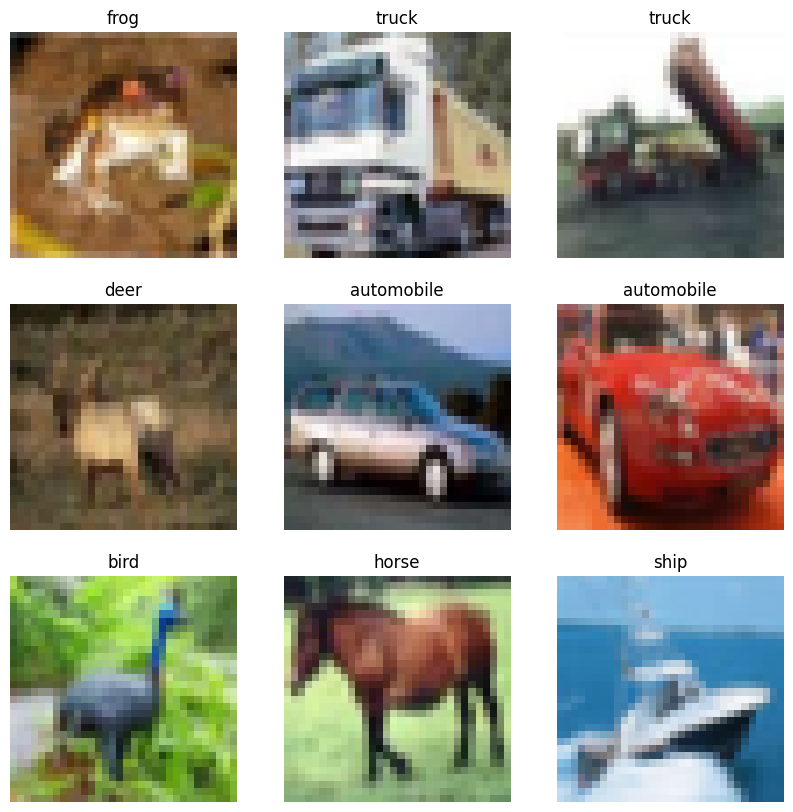

In [7]:
# Plot 9 images from the training set
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i][0]])
    plt.axis("off")

## 3. Model building

### 3.1 Define the model

In [8]:
# Defining a mixed Convolutional Neural Network with MLP head
def hypermodel_builder(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=64, step=16),
                     kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                     padding=hp.Choice('conv_1_padding', values=['same', 'valid']),
                     kernel_regularizer=l2(hp.Choice('conv_1_l2', values=[0.01, 0.001, 0.0001])),
                     activation='relu', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
                     padding=hp.Choice('conv_2_padding', values=['same', 'valid']),
                     kernel_regularizer=l2(hp.Choice('conv_2_l2', values=[0.01, 0.001, 0.0001])),
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(filters=hp.Int('conv_3_filter', min_value=64, max_value=256, step=64),
                     kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
                     kernel_regularizer=l2(hp.Choice('conv_3_l2', values=[0.01, 0.001, 0.0001])),
                     padding=hp.Choice('conv_3_padding', values=['same', 'valid']),
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(units=hp.Int('dense_1_units', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_2_units', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('dense_3_units', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))

    # Compiling the model with Adam optimizer and SparseCategoricalCrossentropy loss function
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])),
                  loss=SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model

### 3.2 Define the hyperparameters and tuner

In [9]:
# Instantiate the tuner
hypertuner = kt.Hyperband(hypermodel_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='cifar-10_hypertuning',
                     project_name='cnn_cifar_10')

In [10]:
# Create a callback to stop training early if no progress is made
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### 3.3 Perform the hyperparameter tuning

In [11]:
# Search for the optimal hyperparameters
hypertuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])

Trial 30 Complete [00h 17m 30s]
val_accuracy: 0.6984000205993652

Best val_accuracy So Far: 0.761900007724762
Total elapsed time: 03h 36m 00s


In [12]:
# Get the optimal hyperparameters
best_hps = hypertuner.get_best_hyperparameters(num_trials=1)[0]

# Print the optimal hyperparameters
for key, value in dict(hypertuner.get_best_hyperparameters()[0].values).items():
    print(f"{key}: {value}")

conv_1_filter: 64
conv_1_kernel: 3
conv_1_padding: same
conv_1_l2: 0.01
conv_2_filter: 128
conv_2_kernel: 5
conv_2_padding: valid
conv_2_l2: 0.001
conv_3_filter: 256
conv_3_kernel: 5
conv_3_l2: 0.01
conv_3_padding: same
dense_1_units: 416
dropout_1: 0.4
dense_2_units: 64
dropout_2: 0.2
dense_3_units: 192
dropout_3: 0.4
learning_rate: 0.0001
None
None
None
None
None


### 3.4 Training the model with the optimal hyperparameters

In [13]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
tuned_model = hypertuner.hypermodel.build(best_hps)
history = tuned_model.fit(x_train, y_train, epochs=50, validation_split=0.2)

# Getting the best epoch - for future reproducibility
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
1250/1250 [==============================] - 161s 128ms/step - loss: 3.3847 - accuracy: 0.3375 - val_loss: 2.6101 - val_accuracy: 0.5059
Epoch 2/50
1250/1250 [==============================] - 158s 127ms/step - loss: 2.3957 - accuracy: 0.5046 - val_loss: 1.9075 - val_accuracy: 0.6145
Epoch 3/50
1250/1250 [==============================] - 164s 131ms/step - loss: 1.8635 - accuracy: 0.5957 - val_loss: 1.5840 - val_accuracy: 0.6520
Epoch 4/50
1250/1250 [==============================] - 162s 130ms/step - loss: 1.5520 - accuracy: 0.6531 - val_loss: 1.4216 - val_accuracy: 0.6773
Epoch 5/50
1250/1250 [==============================] - 162s 130ms/step - loss: 1.3564 - accuracy: 0.6984 - val_loss: 1.2842 - val_accuracy: 0.7168
Epoch 6/50
1250/1250 [==============================] - 166s 133ms/step - loss: 1.2182 - accuracy: 0.7366 - val_loss: 1.2650 - val_accuracy: 0.7125
Epoch 7/50
1250/1250 [==============================] - 161s 129ms/step - loss: 1.1147 - accuracy: 0.7660 - val_

In [17]:
# Rebuild the model with the optimal hyperparameters and train it on the data for the best number of epochs
hypermodel = hypertuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel_history = hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/18
1250/1250 [==============================] - 194s 152ms/step - loss: 3.4011 - accuracy: 0.3269 - val_loss: 2.5924 - val_accuracy: 0.5066
Epoch 2/18
1250/1250 [==============================] - 192s 154ms/step - loss: 2.4005 - accuracy: 0.4915 - val_loss: 1.9736 - val_accuracy: 0.5839
Epoch 3/18
1250/1250 [==============================] - 197s 158ms/step - loss: 1.8714 - accuracy: 0.5833 - val_loss: 1.6125 - val_accuracy: 0.6400
Epoch 4/18
1250/1250 [==============================] - 195s 156ms/step - loss: 1.5583 - accuracy: 0.6491 - val_loss: 1.3818 - val_accuracy: 0.6875
Epoch 5/18
1250/1250 [==============================] - 192s 154ms/step - loss: 1.3684 - accuracy: 0.6952 - val_loss: 1.3469 - val_accuracy: 0.6989
Epoch 6/18
1250/1250 [==============================] - 192s 154ms/step - loss: 1.2239 - accuracy: 0.7342 - val_loss: 1.5296 - val_accuracy: 0.6515
Epoch 7/18
1250/1250 [==============================] - 191s 153ms/step - loss: 1.1232 - accuracy: 0.7664 - val_

### 3.5 Evaluate the model

In [18]:
# Evaluate the model on the test set
eval_result = hypermodel.evaluate(x_test, y_test)

# Print the test loss and test accuracy
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 9s 29ms/step - loss: 1.5310 - accuracy: 0.7336
[test loss, test accuracy]: [1.5309909582138062, 0.7336000204086304]


### 3.6 Saving the model

In [19]:
# Save the tuned model for future reference
hypermodel.save('../Models/hypertuned-cifar-cnn-model.keras')

## 4. Recreate the best model, train it and evaluate it

In [20]:
tuned_model = Sequential([
    # Convolutional layers
    Conv2D(64, 3, activation='relu', kernel_regularizer=l2(0.01), padding='same',
            input_shape=(32, 32, 3)),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Conv2D(128, 5, activation='relu', kernel_regularizer=l2(0.001), padding='valid'),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Conv2D(256, 5, activation='relu', kernel_regularizer=l2(0.01), padding='same'),
    MaxPooling2D((2,2)),
    BatchNormalization(),
    Flatten(),

    # Dense layers
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
])

In [21]:
tuned_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss=SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

This time the model uses better data optimizations, batching and data shuffling

In [23]:
# Transform numpy arrays to tensorflow datasets
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Shuffle and batch train and test data + cache and prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 64

train = (
    train
    .shuffle(1000)
    .batch(batch_size)
    .cache()
    .prefetch(AUTOTUNE)
)

test = (
    test
    .batch(batch_size)
    .cache()
    .prefetch(AUTOTUNE)
)

In [27]:
tuned_model_history = tuned_model.fit(train, batch_size=64, shuffle=True, epochs=20, validation_data=test)

Epoch 1/20


782/782 [==============================] - 156s 200ms/step - loss: 2.0838 - accuracy: 0.6047 - val_loss: 1.5885 - val_accuracy: 0.7344
Epoch 2/20
782/782 [==============================] - 156s 200ms/step - loss: 1.7084 - accuracy: 0.6603 - val_loss: 1.4312 - val_accuracy: 0.7300
Epoch 3/20
782/782 [==============================] - 151s 193ms/step - loss: 1.4402 - accuracy: 0.7038 - val_loss: 1.0421 - val_accuracy: 0.8323
Epoch 4/20
782/782 [==============================] - 157s 200ms/step - loss: 1.2553 - accuracy: 0.7425 - val_loss: 0.9097 - val_accuracy: 0.8519
Epoch 5/20
782/782 [==============================] - 160s 205ms/step - loss: 1.1075 - accuracy: 0.7743 - val_loss: 0.7898 - val_accuracy: 0.8854
Epoch 6/20
782/782 [==============================] - 153s 195ms/step - loss: 0.9908 - accuracy: 0.8044 - val_loss: 0.7018 - val_accuracy: 0.9047
Epoch 7/20
782/782 [==============================] - 152s 194ms/step - loss: 0.9046 - accuracy: 0.8303 - val_loss: 0.6098 - val_accura

Printing the evaluation metrics

In [28]:
eval_result = tuned_model.evaluate(test)
print("[test loss, test accuracy]:", eval_result)

157/157 [==============================] - 7s 42ms/step - loss: 1.4800 - accuracy: 0.7491
[test loss, test accuracy]: [1.4799563884735107, 0.7491000294685364]


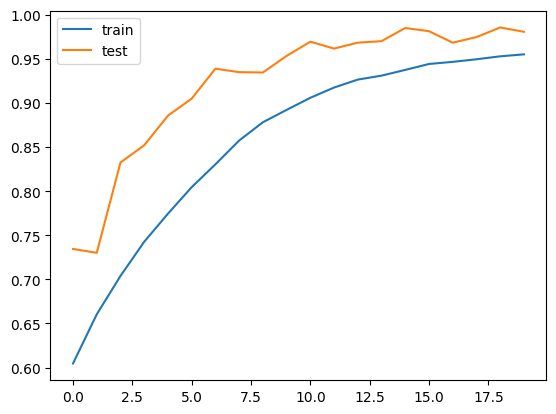

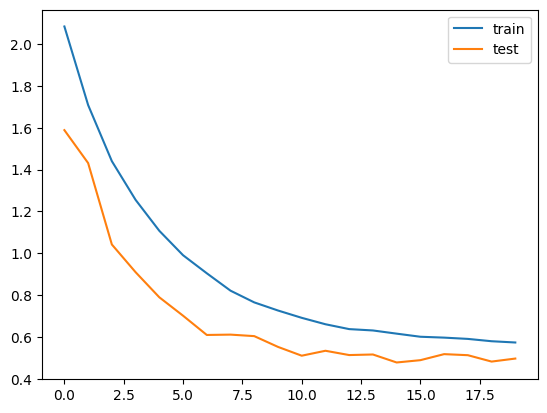

In [29]:
# Plot the accuracy and loss curves
plt.plot(tuned_model_history.history['accuracy'], label='train')
plt.plot(tuned_model_history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

plt.plot(tuned_model_history.history['loss'], label='train')
plt.plot(tuned_model_history.history['val_loss'], label='test')
plt.legend()
plt.show()

Save the model once more

In [30]:
tuned_model.save('../Models/tuned-cifar-cnn-model.keras')

## 5. Display the Confusion matrix

  1/157 [..............................] - ETA: 9s

157/157 [==============================] - 7s 42ms/step


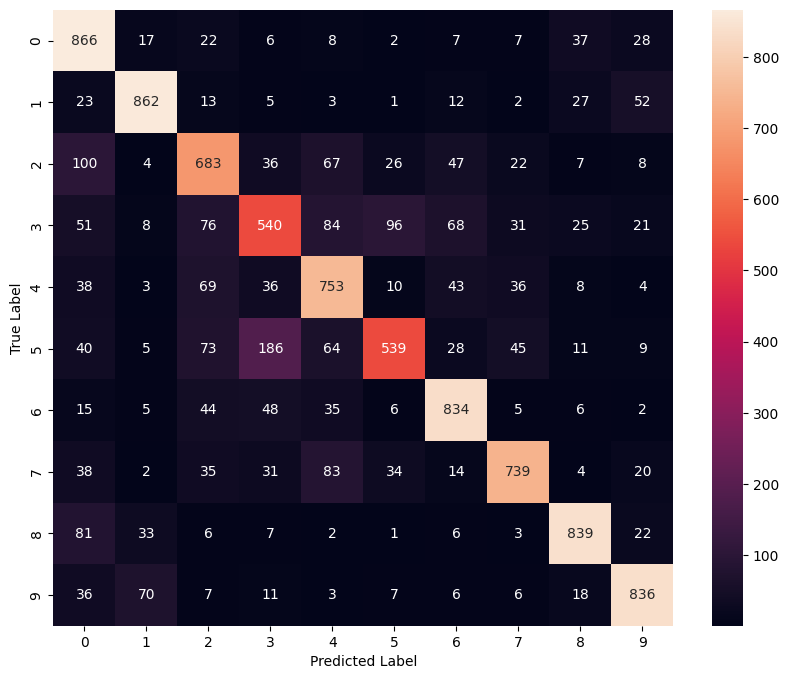

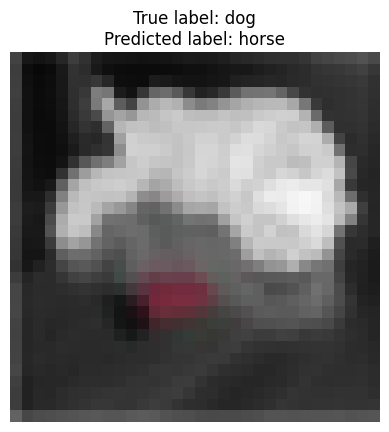

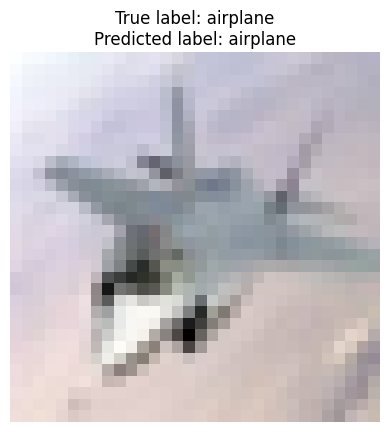

In [35]:
# Display the confusion matrix
y_pred = tuned_model.predict(test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = y_test

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Display some misclassified images
misclassified_idx = np.where(y_pred_classes != y_true)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i])
plt.title(f"True label: {class_names[y_true[i][0]]}\nPredicted label: {class_names[y_pred_classes[i]]}")
plt.axis('off')
plt.show()

# Display some correctly classified images
correctly_classified_idx = np.where(y_pred_classes == y_true)[0]
i = np.random.choice(correctly_classified_idx)
plt.imshow(x_test[i])
plt.title(f"True label: {class_names[y_true[i][0]]}\nPredicted label: {class_names[y_pred_classes[i]]}")
plt.axis('off')
plt.show()

# The End